In [5]:
import numpy as np
from matplotlib.path import Path
from matplotlib import pyplot as plt
import pickle

import warnings

import sys
sys.path.insert(0,'../src/')

from utils import *
from multiply_connected_pipe import *
from multiply_connected_pipe.smooth_pipe import SmoothPipe
from curve import *

In [6]:
class straight_pipe(SmoothPipe):
    
    def __init__(self, l:np.float64, d:np.float64) -> None:
        
        assert l > 0
        assert d > 0

        r = d/2
        p1 = pt(0,r)
        p2 = pt(0,-r)
        p3 = pt(l,-r)
        p4 = pt(l,r)
        
        c1 = Cap
        c2 = Line
        c3 = Cap
        c4 = Line
        
        pts = [p1,p2,p3,p4]
        lines = [c1,c2,c3,c4]
        
        super().__init__(pts, lines)
        
    def boundary_value(self, flow_index):
        assert flow_index == 0
        h = [self.velocity_with_flux_zero()]
        for i,c in enumerate(self.curves[1:]):
            h.append(np.zeros_like(c.a))
        
        return np.concatenate(h)
        
    def velocity_with_flux_zero(self,r=.5):
        frequencies = np.random.uniform(0,100,size=10)
        
        t = self.curves[0].t
        dt = self.curves[0].dt_da*self.curves[0].dt_da
        
        profile = np.sum(np.exp(t[:,np.newaxis]*frequencies[np.newaxis,:]*np.pi),axis=1)
        
        t_ends = np.array([-r*1j,r*1j])
        value_at_ends = np.sum(np.exp(t_ends[:,np.newaxis]*frequencies[np.newaxis,:]*2*np.pi),axis=1)
        
        k = np.diff(value_at_ends)/np.diff(t_ends)
        
        b = -k*t_ends[0] + value_at_ends[0]
        
        profile = profile - k*t - b
        # profile /= np.linalg.norm(profile)
        
        return profile
    

In [7]:
pipe = straight_pipe(8,1)

In [8]:
pipe.build(required_tol=1e-10,density=40,fmm=True)

/home/haiy/pkg/fmm2d/python/fmm2dpy/fmm2d.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  out.pottarg,out.gradtarg,out.ier = lfmm.cfmm2d_t_d_g(eps,sources,dipstr,targets)


         62220920 function calls (62189107 primitive calls) in 47.179 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 12164320   20.290    0.000   28.012    0.000 cap.py:75(_Psi)
     1224    7.673    0.006    7.693    0.006 linalg.py:320(solve)
 24396649    3.618    0.000    7.308    0.000 {built-in method builtins.isinstance}
       19    3.478    0.183    3.478    0.183 fmm2d.py:976(bhfmm2d)
    21864    2.706    0.000   29.941    0.001 {built-in method scipy.integrate._quadpack._qagse}
        6    2.097    0.350    2.098    0.350 fmm2d.py:720(cfmm2d)
 12185733    1.855    0.000    1.855    0.000 {built-in method _abc._abc_instancecheck}
 12185733    1.836    0.000    3.690    0.000 abc.py:117(__instancecheck__)
      952    0.576    0.001   16.232    0.017 panel.py:216(get_pr)
     2832    0.420    0.000    0.428    0.000 legendre.py:832(legval)
    18016    0.145    0.000    0.187    0.000 linear_transform.py:28(__ca

In [9]:
pipe.t.shape


(1632,)

In [10]:
u,v,p,o = pipe.fields_with_fluxes(np.array([1]),0,0)
xs = pipe.xs
ys = pipe.ys

In [11]:
x = np.linspace(0,8,100)[1:]
y = np.exp(-4.2*x)

v_max = []
p_max = []
o_max = []

for up,low in zip(x[1:],x[:-1]):
    m = (xs <= up) & (xs >= low)
    v_max.append(np.max(np.sqrt(u[m]**2 + v[m]**2)))
    p_max.append(np.max(np.abs(p[m])))
    o_max.append(np.max(np.abs(o[m])))

# Plots and explainations

This notebook demonstrates the return to poiseuille phenomemnon on a straight pipe. The left boundary of the straight pipe is assigned with a random velocity condition with zero flux, and other parts of the boundary have zero velocity bounndary condition. 

**Return to poiseuille** dictates that the flow should decay as $e^{-4.4 x}$, as going to the right hand side of the pipe, which is true in our case. This is verified in our numerical experiements, for $x < 7$, for which the flow is roughly bounded by $10^{-14}$. After that, I guess that the near panel interaction correction's error dominates, so we cannot observe the decay as expected. This probably could be fixed by requiring more panels. 

- The velocity boundary condition
  1. on the left side of the boundary, a randomly generated velocity profile with zero flux is assigned. It is generated by $\sum_j \exp(yi\lambda_j)$, where $\lambda_j$ are 10 numbers from uniform random variable of range $[0,100]$. It is normalized by a linear function to have zero flux as well as zero velocity on the boundary. 
  2. elsewhere, the velocity is zero. 



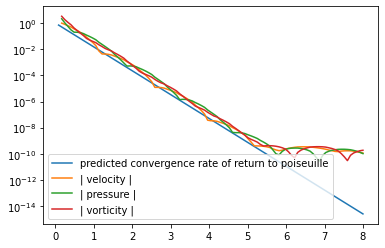

In [12]:
plt.semilogy(x,y,label='predicted convergence rate of return to poiseuille')
plt.semilogy(x[1:],v_max,label='| velocity |')
plt.semilogy(x[1:],p_max,label='| pressure |')
plt.semilogy(x[1:],o_max,label='| vorticity |')
plt.legend()

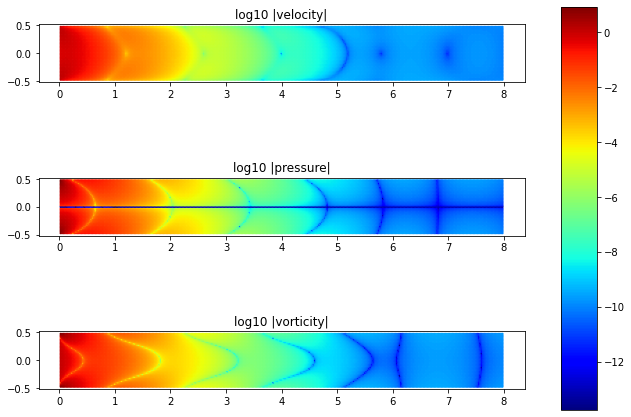

In [13]:
fig,axes = plt.subplots(3,1,figsize=(10,8))
fig.set_facecolor('white')
# fig.suptitle('Return to Poiseuille demostration.\n The boundary conditions consists of\n a with a random profile with zero flux on the left side,\n and zero elsewhere.\n (random velocity profile is generated by sum of functions of the form exp(yi\lambda) where \lambda is a random frequency from 0 to 100) on the left boundary.')

fields = [np.log10(np.sqrt(u**2 + v**2)),np.log10(np.abs(p)),np.log10(np.abs(o))]

vmin = np.min([np.min(f[np.isfinite(f)]) for f in fields])
vmax = np.max([np.max(f) for f in fields])

for ax, field,title in zip(axes,fields,['log10 |velocity|','log10 |pressure|','log10 |vorticity|']):
    ax.set_aspect('equal')
    ax.set_title(title)
    im = ax.scatter(xs,ys,c=field,s=1.5,cmap='jet',vmin=vmin,vmax=vmax)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

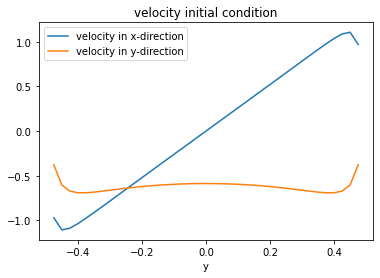

In [14]:
m = xs == np.min(xs)
x = xs[m]
y = ys[m]
plt.plot(y,u[m],label='velocity in x-direction')
plt.plot(y,v[m],label='velocity in y-direction')
plt.title("velocity initial condition")
plt.xlabel('y')
plt.legend()